# Fama-French 3 Factor model (Python conversion)
This notebook translates the original R workflow into Python while preserving the analytical steps for factor investing.

## Environment setup
Import Python libraries for numerical analysis, plotting, and data access.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import yfinance as yf

import statsmodels.api as sm
from IPython.display import display

#from helpers import get_yahoo_data

plt.style.use("seaborn-v0_8")
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")
sns.set_palette("deep")

## Data preparation
Define the investment universe and download daily prices from Yahoo Finance using the shared helper.

In [60]:
start_date = "2017-01-01"
end_date = "2025-09-30"
tickers = ["AAPL", "AMZN", "NFLX", "GOOG", "META", "XOM", "GM", "T", "WMT", "SBUX"]
market_ticker = "^GSPC"
interval = "1mo"

stocks_raw = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    interval=interval,
    group_by='ticker',
    auto_adjust=False,
    threads=True,
    progress=False
)
market_raw = yf.download(
    tickers=market_ticker,
    start=start_date,
    end=end_date,
    interval=interval,
    group_by='ticker',
    auto_adjust=False,
    threads=True,
    progress=False
)

stock_prices=stocks_raw.xs("Adj Close", level=1, axis=1).copy()
market_prices=market_raw.xs("Adj Close", level=1, axis=1).copy()
display(stock_prices.head())

Ticker,NFLX,GM,META,SBUX,AMZN,AAPL,WMT,XOM,GOOG,T
Date,,,,,,,,,,
2017-01-01,140.710007,30.957949,129.521545,45.860058,41.174000,27.996515,19.119116,56.536968,39.568718,16.687925
2017-02-01,142.130005,31.152451,134.709564,47.230385,42.251999,31.604813,20.319435,54.804935,40.880745,16.796978
2017-03-01,147.809998,29.900932,141.179657,48.711258,44.327000,33.287338,20.648880,55.775352,41.196083,16.700508
2017-04-01,152.199997,29.591795,149.329437,50.104439,46.249500,33.285015,21.695301,55.530518,44.990124,15.928791
2017-05-01,163.070007,28.985262,150.532013,53.065987,49.730999,35.395885,22.682241,54.748402,47.915104,15.732539


In [61]:
stock_returns = np.log(stock_prices / stock_prices.shift(1)).dropna()
market_returns = np.log(market_prices / market_prices.shift(1)).dropna()

stock_returns, market_returns = stock_returns.align(market_returns, join="inner", axis=0)

num_assets = stock_returns.shape[1]
num_obs = stock_returns.shape[0]
print(f"Number of assets: {num_assets}")
print(f"Number of observations: {num_obs}")
stock_returns.cov()

Number of assets: 10
Number of observations: 104


Ticker,NFLX,GM,META,SBUX,AMZN,AAPL,WMT,XOM,GOOG,T
Ticker,,,,,,,,,,
NFLX,0.014821,0.003752,0.004146,0.002284,0.006684,0.003471,0.001502,0.000407,0.003471,0.000393
GM,0.003752,0.010161,0.003567,0.002694,0.002275,0.003027,0.001339,0.003784,0.002903,0.002025
META,0.004146,0.003567,0.011392,0.002878,0.004697,0.003152,0.001634,0.000385,0.003393,0.000735
SBUX,0.002284,0.002694,0.002878,0.005973,0.002044,0.001617,0.000860,0.001520,0.001577,0.001294
AMZN,0.006684,0.002275,0.004697,0.002044,0.007553,0.003801,0.001407,0.000763,0.003933,-0.000204
AAPL,0.003471,0.003027,0.003152,0.001617,0.003801,0.006390,0.001427,0.001319,0.002695,0.000906
WMT,0.001502,0.001339,0.001634,0.000860,0.001407,0.001427,0.003069,0.000434,0.000983,0.000334
XOM,0.000407,0.003784,0.000385,0.001520,0.000763,0.001319,0.000434,0.006786,0.001214,0.002256
GOOG,0.003471,0.002903,0.003393,0.001577,0.003933,0.002695,0.000983,0.001214,0.005226,0.000331


## Single market factor model
Estimate CAPM-style alphas and betas using least squares and inspect the implied covariance matrix.

In [62]:
X = stock_returns.to_numpy()
f = market_returns.to_numpy().reshape(-1, 1)

X_centered = X - X.mean(axis=0)
f_centered = f - f.mean(axis=0)

cov_xf = (X_centered * f_centered).sum(axis=0) / (len(f_centered) - 1)
market_var = float((f_centered ** 2).sum() / (len(f_centered) - 1))

beta_ls = cov_xf / market_var
# ensure market mean is a scalar (not a length-1 Series) to avoid alignment issues
market_mean = float(market_returns.mean().to_numpy().squeeze())
alpha_ls = stock_returns.mean().to_numpy() - beta_ls * market_mean
single_factor_params = pd.DataFrame({"alpha": alpha_ls, "beta": beta_ls}, index=stock_returns.columns)
single_factor_params

,alpha,beta
Ticker,,
NFLX,0.006498,1.362172
GM,-0.008024,1.402126
META,0.003547,1.268289
SBUX,-0.003458,0.902765
AMZN,0.003140,1.251284
AAPL,0.009330,1.149255
WMT,0.010331,0.566767
XOM,-0.002649,0.896953
GOOG,0.006583,1.051127


The closed-form solution mirrors the R implementation: betas are the asset-market covariances divided by market variance, and alphas adjust for the average market return.

In [63]:
predicted_returns = alpha_ls + f * beta_ls
residuals = X - predicted_returns
sigma2 = (residuals ** 2).sum(axis=0) / (len(f_centered) - 2)
Psi_diag = np.diag(sigma2)
Sigma_1factor = market_var * np.outer(beta_ls, beta_ls) + Psi_diag

Psi_df = pd.DataFrame(Psi_diag, index=stock_returns.columns, columns=stock_returns.columns)
Sigma_1factor_df = pd.DataFrame(Sigma_1factor, index=stock_returns.columns, columns=stock_returns.columns)
Sigma_1factor_df

Ticker,NFLX,GM,META,SBUX,AMZN,AAPL,WMT,XOM,GOOG,T
Ticker,,,,,,,,,,
NFLX,0.014928,0.004029,0.003644,0.002594,0.003595,0.003302,0.001628,0.002577,0.003020,0.001617
GM,0.004029,0.010220,0.003751,0.002670,0.003701,0.003399,0.001676,0.002653,0.003109,0.001665
META,0.003644,0.003751,0.011471,0.002415,0.003348,0.003075,0.001516,0.002400,0.002812,0.001506
SBUX,0.002594,0.002670,0.002415,0.006014,0.002383,0.002188,0.001079,0.001708,0.002002,0.001072
AMZN,0.003595,0.003701,0.003348,0.002383,0.007595,0.003033,0.001496,0.002367,0.002774,0.001486
AAPL,0.003302,0.003399,0.003075,0.002188,0.003033,0.006425,0.001374,0.002174,0.002548,0.001364
WMT,0.001628,0.001676,0.001516,0.001079,0.001496,0.001374,0.003092,0.001072,0.001257,0.000673
XOM,0.002577,0.002653,0.002400,0.001708,0.002367,0.002174,0.001072,0.006836,0.001989,0.001065
GOOG,0.003020,0.003109,0.002812,0.002002,0.002774,0.002548,0.001257,0.001989,0.005255,0.001248


Residual variances (`Psi`) capture idiosyncratic risk, and combining them with the systematic component reconstructs the full covariance matrix.

### Matrix form solution
Solve the regression simultaneously for all assets using matrix algebra, matching the R `Gamma` estimate.

In [64]:
F_matrix = np.column_stack([np.ones(len(market_returns)), market_returns.to_numpy()])
Gamma = np.linalg.lstsq(F_matrix, stock_returns.to_numpy(), rcond=None)[0]
alpha_matrix = pd.Series(Gamma[0], index=stock_returns.columns, name="alpha")
beta_matrix = pd.Series(Gamma[1], index=stock_returns.columns, name="beta")
pd.concat([alpha_matrix, beta_matrix], axis=1)

,alpha,beta
Ticker,,
NFLX,0.006498,1.362172
GM,-0.008024,1.402126
META,0.003547,1.268289
SBUX,-0.003458,0.902765
AMZN,0.003140,1.251284
AAPL,0.009330,1.149255
WMT,0.010331,0.566767
XOM,-0.002649,0.896953
GOOG,0.006583,1.051127


In [65]:
E = stock_returns.to_numpy() - F_matrix @ Gamma
Psi_matrix = (E.T @ E) / (len(market_returns) - F_matrix.shape[1])
Psi_matrix_df = pd.DataFrame(Psi_matrix, index=stock_returns.columns, columns=stock_returns.columns)
Sigma_matrix = market_var * np.outer(beta_matrix, beta_matrix) + np.diag(np.diag(Psi_matrix))
Sigma_matrix_df = pd.DataFrame(Sigma_matrix, index=stock_returns.columns, columns=stock_returns.columns)
Psi_matrix_df

Ticker,NFLX,GM,META,SBUX,AMZN,AAPL,WMT,XOM,GOOG,T
Ticker,,,,,,,,,,
NFLX,0.011014,-0.000280,0.000507,-0.000313,0.003118,0.000171,-0.000127,-0.002192,0.000455,-0.001236
GM,-0.000280,0.006073,-0.000186,0.000025,-0.001439,-0.000375,-0.000341,0.001142,-0.000207,0.000364
META,0.000507,-0.000186,0.008078,0.000467,0.001363,0.000078,0.000119,-0.002034,0.000587,-0.000778
SBUX,-0.000313,0.000025,0.000467,0.004295,-0.000342,-0.000577,-0.000221,-0.000190,-0.000429,0.000224
AMZN,0.003118,-0.001439,0.001363,-0.000342,0.004292,0.000776,-0.000090,-0.001620,0.001170,-0.001706
AAPL,0.000171,-0.000375,0.000078,-0.000577,0.000776,0.003639,0.000054,-0.000864,0.000148,-0.000463
WMT,-0.000127,-0.000341,0.000119,-0.000221,-0.000090,0.000054,0.002415,-0.000645,-0.000276,-0.000342
XOM,-0.002192,0.001142,-0.002034,-0.000190,-0.001620,-0.000864,-0.000645,0.005139,-0.000782,0.001203
GOOG,0.000455,-0.000207,0.000587,-0.000429,0.001170,0.000148,-0.000276,-0.000782,0.002924,-0.000926


The matrix solution reproduces the scalar calculations and keeps the workflow vectorised, which is faster for larger universes.

### Visualising covariance structures
Heatmaps provide an immediate view of the correlation patterns implied by the single-factor model and its residuals.

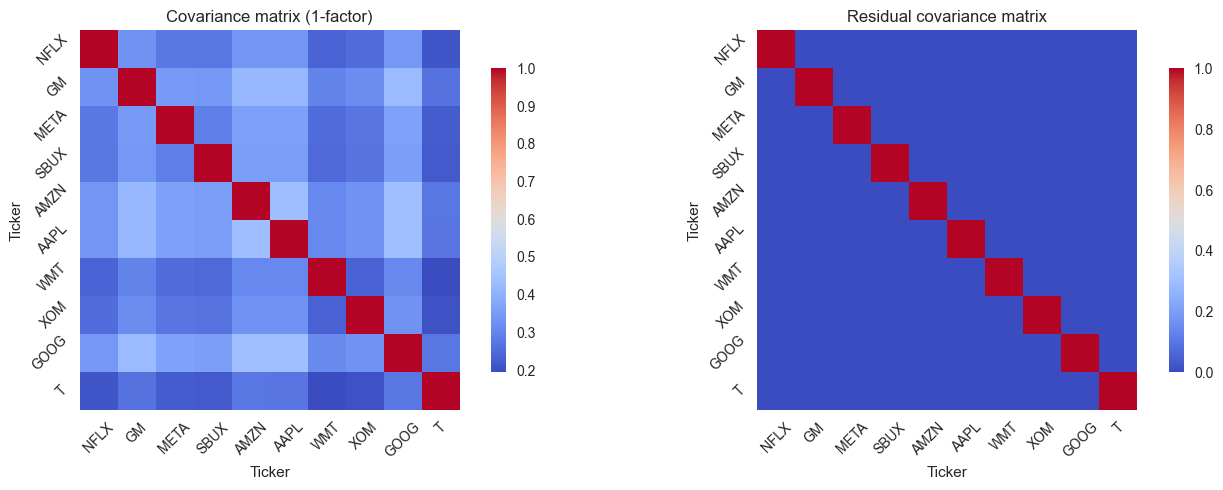

In [66]:
def covariance_to_correlation(cov_df: pd.DataFrame) -> pd.DataFrame:
    values = cov_df.to_numpy()
    std = np.sqrt(np.diag(values))
    corr = values / np.outer(std, std)
    return pd.DataFrame(corr, index=cov_df.index, columns=cov_df.columns)

corr_sigma = covariance_to_correlation(Sigma_1factor_df)
corr_residuals = covariance_to_correlation(Psi_df)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(corr_sigma, cmap="coolwarm", square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title("Covariance matrix (1-factor)")
sns.heatmap(corr_residuals, cmap="coolwarm", square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title("Residual covariance matrix")
for ax in axes:
    ax.tick_params(labelrotation=45)
plt.tight_layout()
plt.show()

## Fama-French multi-factor model
Extend the analysis by loading Fama-French research factors (3F or 5F) and fitting the macro factor model.

In [67]:
from pathlib import Path

def load_fama_french_daily(model: str = "5F"):
    model = model.upper()
    zip_candidates = {
        "3F": "F-F_Research_Data_Factors_daily_CSV.zip",
        "5F": "F-F_Research_Data_5_Factors_2x3_daily_CSV.zip",
    }
    csv_expected = {
        "3F": "F-F_Research_Data_Factors_daily.CSV",
        "5F": "F-F_Research_Data_5_Factors_2x3_daily.CSV",
    }
    skiprows = {"3F": 4, "5F": 3}
    if model not in zip_candidates:
        raise ValueError("model must be '3F' or '5F'")

    cwd = Path(".")
    zip_path = cwd / zip_candidates[model]
    csv_path = cwd / csv_expected[model]

    raw = None
    # Prefer zipped file if present
    if zip_path.exists():
        with ZipFile(zip_path) as zf:
            inner_name = csv_expected[model]
            if inner_name not in zf.namelist():
                # fallback: pick first CSV inside the zip
                candidates = [n for n in zf.namelist() if n.lower().endswith(".csv")]
                if not candidates:
                    raise FileNotFoundError(f"No CSV found inside {zip_path}")
                inner_name = candidates[0]
            with zf.open(inner_name) as file:
                raw = pd.read_csv(file, skiprows=skiprows[model])
    elif csv_path.exists():
        raw = pd.read_csv(csv_path, skiprows=skiprows[model])
    else:
        # attempt to find any local Fama-French daily zip/csv in cwd
        for p in cwd.glob("*"):
            if p.is_file() and ("F-F" in p.name or "Fama" in p.name) and p.suffix.lower() in {".zip", ".csv"}:
                if p.suffix.lower() == ".zip":
                    with ZipFile(p) as zf:
                        candidates = [n for n in zf.namelist() if n.lower().endswith(".csv")]
                        if not candidates:
                            continue
                        with zf.open(candidates[0]) as file:
                            raw = pd.read_csv(file, skiprows=skiprows[model])
                            break
                else:
                    raw = pd.read_csv(p, skiprows=skiprows[model])
                    break
        if raw is None:
            raise FileNotFoundError(
                "Could not find the Fama-French daily file in the current folder. "
                "Place the appropriate zip or csv in the working directory."
            )

    raw = raw.rename(columns=lambda c: c.strip())
    date_strings = raw.iloc[:, 0].astype(str).str.strip()
    parsed_dates = pd.to_datetime(date_strings, format="%Y%m%d", errors="coerce")
    valid_mask = parsed_dates.notna()
    numeric = raw.loc[valid_mask].copy()
    numeric.index = pd.DatetimeIndex(parsed_dates[valid_mask])
    numeric.index.name = "date"
    numeric = numeric.apply(pd.to_numeric, errors="coerce").dropna()
    numeric = numeric / 100.0

    factor_cols = [col for col in numeric.columns if col.upper() != "RF"]
    factors = numeric[factor_cols]
    rf_candidates = [col for col in numeric.columns if col.upper() == "RF"]
    if rf_candidates:
        risk_free = numeric[rf_candidates[0]]
    else:
        risk_free = pd.Series(index=numeric.index, dtype=float)
    return factors, risk_free

The loader downloads the zipped CSV directly, parses the dates, converts the factors to decimals, and separates the excess return factors from the risk-free series.

In [77]:
FF_MODEL = "5F"
ff_factors, ff_rf = load_fama_french_daily(FF_MODEL)
if "Unnamed: 0" in ff_factors.columns:
    ff_factors = ff_factors.drop(columns=["Unnamed: 0"])
common_dates = ff_factors.index.intersection(stock_returns.index)
aligned_returns = stock_returns.loc[common_dates]
aligned_factors = ff_factors.loc[common_dates]

We align factor and asset returns on the common trading dates to keep the regression well-defined.

In [78]:
def fit_factor_model(asset_returns: pd.DataFrame, factor_data: pd.DataFrame):
    y = asset_returns.to_numpy()
    X = np.column_stack([np.ones(len(factor_data)), factor_data.to_numpy()])
    coeffs, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    alpha = pd.Series(coeffs[0], index=asset_returns.columns, name="alpha")
    beta = pd.DataFrame(coeffs[1:], index=factor_data.columns, columns=asset_returns.columns)
    fitted = X @ coeffs
    residuals = y - fitted
    residuals_df = pd.DataFrame(residuals, index=factor_data.index, columns=asset_returns.columns)
    return alpha, beta, residuals_df

ff_alpha, ff_beta, ff_residuals = fit_factor_model(aligned_returns, aligned_factors)
ff_results = pd.concat([ff_alpha, ff_beta.T], axis=1)
ff_results

,alpha,Mkt-RF,SMB,HML,RMW,CMA
Ticker,,,,,,
NFLX,0.009404,-0.159803,-1.243577,1.730398,1.039127,-4.635335
GM,0.005475,-0.181212,1.746140,0.361190,2.208763,-3.923189
META,0.013693,-1.522826,3.310477,-1.735004,3.518479,-3.002987
SBUX,0.010061,-0.331301,-1.214214,0.191074,2.053658,-1.218438
AMZN,0.011132,-0.282780,-0.111432,0.518047,-1.301018,-1.882525
AAPL,0.024021,-1.291142,-2.733093,4.162007,-3.303736,-4.067160
WMT,0.016477,0.192030,-2.201620,-0.425603,-0.431247,1.575420
XOM,0.002412,-0.199645,0.485878,0.118456,-0.205182,-0.063583
GOOG,0.015146,-0.489090,-0.164975,1.247569,-0.217376,-0.778966


The resulting table mirrors the `cbind(alpha, beta)` output from R, with one row per stock and one column per factor.

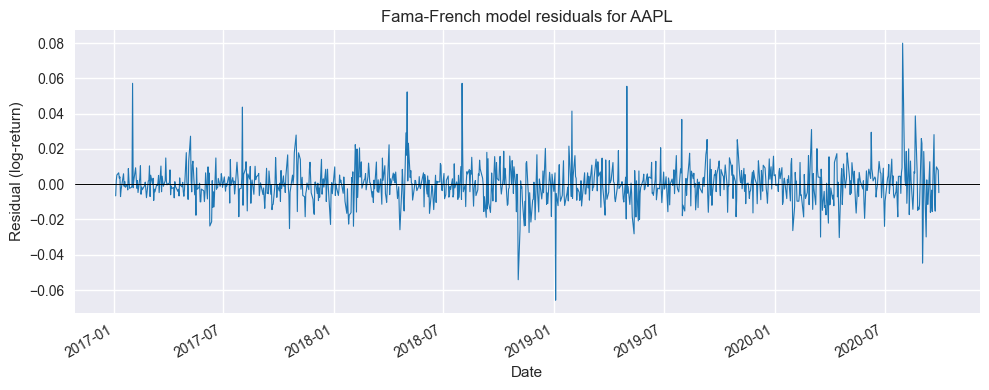

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
ff_residuals["AAPL"].plot(ax=ax, lw=0.8, color="tab:blue")
ax.axhline(0, color="black", lw=0.7)
ax.set_title("Fama-French model residuals for AAPL")
ax.set_ylabel("Residual (log-return)")
plt.tight_layout()
plt.show()

Residual dynamics resemble the R plot and highlight periods where the five-factor model leaves material unexplained variation.

In [21]:
aapl_returns = aligned_returns["AAPL"]
X = sm.add_constant(ff_factors)
ff_ols = sm.OLS(aapl_returns, X).fit()
ff_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     331.4
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          2.20e-227
Time:                        23:49:08   Log-Likelihood:                 2889.6
No. Observations:                 941   AIC:                            -5765.
Df Residuals:                     934   BIC:                            -5731.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3732      0.689     -0.542      0.588      -1.725       0.978
Unnamed: 0  1.851e-06   3.41e-06      0.542      0.588   -4.85e-06    8.55e-06
Mkt-RF         1.2414      0.030     41.718      0.000       1.183       1.300
SMB           -0.2846      0.063     -4.552      0.000      -0.407      -0.162
HML           -0.4576      0.055     -8.252      0.000      -0.566      -0.349
RMW            0.5173      0.098      5.253      0.000       0.324       0.711
CMA           -0.1470      0.121     -1.213      0.226      -0.385       0.091
==============================================================================
Omnibus:                      194.202   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1943.259
Skew:                           0.631   Prob(JB):                         0.00
Kurtosis:                       9.926   Cond. No.                     3.79e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.79e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""